In [218]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os
import math

from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader, ConcatDataset
from matplotlib.lines import Line2D
from collections import Counter
from datetime import datetime

seed = 265
torch.manual_seed(seed)

device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cpu.


In [219]:
# ----------------------- Setup ----------------------------
PATH_GENERATED = './generated/'

vocab = torch.load(PATH_GENERATED + 'vocabulary.pt', map_location=torch.device(device))
embedding = torch.load(PATH_GENERATED + 'embedding.pt', map_location=torch.device(device))
(VOCAB_SIZE, embedding_dim) = embedding.weight.shape  

words_train = torch.load(PATH_GENERATED + "words_train.pt", map_location=torch.device(device))
words_val   = torch.load(PATH_GENERATED + "words_val.pt", map_location=torch.device(device))
words_test  = torch.load(PATH_GENERATED + "words_test.pt", map_location=torch.device(device))

In [243]:
CONTEXT_SIZE = 10

def create_dataset(text, vocab, context_size=CONTEXT_SIZE):
    
    # Transform each word to its index in the vocabulary.
    txt = [vocab[w] for w in text]

    n_text = len(text)

    contexts = []
    targets = []
    for i in range(n_text - context_size):
        
        t = txt[i + context_size]
        if  vocab.lookup_token(t) in ['<unk>']: continue # We only want to guess known words.
        c = txt[i:i + context_size]
        
        targets.append(t - 1) 
        contexts.append(torch.tensor(c).to(device=device))
            
    contexts = torch.stack(contexts)
    targets = torch.tensor(targets).to(device=device)
    return TensorDataset(contexts, targets)

In [244]:
def load_dataset(words, vocab, fname):
    """
    Load dataset if already generated, otherwise, create it and save it
    """
    
    if os.path.isfile(PATH_GENERATED + fname):
        dataset = torch.load(PATH_GENERATED + fname, map_location=torch.device(device))
    else:
        dataset = create_dataset(words, vocab)
        torch.save(dataset, PATH_GENERATED + fname)
    return dataset

data_train_gen = load_dataset(words_train, vocab, "gen_data_train.pt")
data_val_gen   = load_dataset(words_val, vocab, "gen_data_val.pt")
data_test_gen  = load_dataset(words_test, vocab, "gen_data_test.pt")

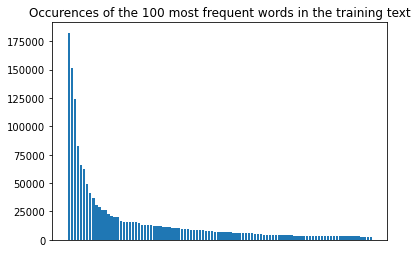

The frequencies of the words are very skewed. We need to weigh the words for the CE loss function.


In [245]:
target_words_idx = data_train_gen[:][1].tolist()
target_words = [vocab.lookup_token(i) for i in target_words_idx]
counts = Counter(target_words)
most_freq = counts.most_common(100)
most_freq_words = [t[0] for t in most_freq]
most_freq_values = [t[1] for t in most_freq]


plt.bar(most_freq_words, height=most_freq_values)
plt.xticks([])
plt.title("Occurences of the 100 most frequent words in the training text")
plt.show()
print("The frequencies of the words are very skewed. We need to weigh the words for the CE loss function.")

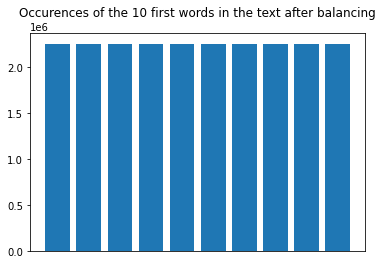

In [246]:
def calculate_word_weights(counts):
    """
    Calculate the weight of each word so that the loss function can weigh 
    frequent words less and unfrequent words more.
    """
    total_words = counts.total()
    word_weights = [(total_words / value) for value in counts.values()] 
    word_weights = torch.tensor(word_weights, dtype=torch.float).to(device=device)
    return word_weights

word_weigts = calculate_word_weights(counts)
values_balanced = [int(list(counts.values())[i])*w for i, w in enumerate(word_weigts)]
plt.bar(list(counts.keys())[:10], height=values_balanced[:10])
plt.xticks([])
plt.title("Occurences of the 10 first words in the text after balancing")
plt.show()

In [247]:
# ---------------- RNN MLP hyper parameters ----------------------- 
lrs = [0.1, 0.01, 0.001]
rnn_hparams = [{
    'lr': lr,
} for lr in lrs]

train_loader = DataLoader(data_test_gen, batch_size=128, shuffle=True)
val_loader = DataLoader(data_val_gen, batch_size=128, shuffle=True)
test_loader = DataLoader(data_test_gen, batch_size=128, shuffle=True)

In [248]:
# ---------------- Train and accuracy -----------------------
def train(n_epochs, optimizer, model, loss_fn, train_loader):

    n_batch = len(train_loader)
    losses_train = []
    model.train()
    optimizer.zero_grad(set_to_none=True)

    for epoch in range(1, n_epochs + 1):

        loss_train = 0.0
        for contexts, targets in train_loader:

            contexts = contexts.to(device=device)
            targets = targets.to(device=device)

            outputs = model(contexts)

            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            loss_train += loss.item()

        losses_train.append(loss_train / n_batch)

        if epoch == 1 or epoch % 5 == 0:
            print('{}  |  Epoch {}  |  Training loss {:.5f}'.format(
                datetime.now().time(), epoch, loss_train / n_batch))
    return losses_train

def compute_accuracy(model, loader):
    """
    Computes accuracy as correctly predicted / total 
    """
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for contexts, targets in loader:
            contexts = contexts.to(device=device)
            targets = targets.to(device=device)

            outputs = model(contexts)
            _, predicted = torch.max(outputs, dim=1)
            total += len(targets)
            correct += int((predicted == targets).sum())

    acc =  correct / total
    return acc

In [249]:
class RNN(nn.Module):
    def __init__(self, embedding):
        super().__init__()

        self.embedding = nn.Embedding(VOCAB_SIZE, embedding_dim)
        self.embedding.load_state_dict(embedding.state_dict())
        for p in self.embedding.parameters():
            p.requires_grad = False

        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=len(counts), batch_first=True)

    def forward(self, x):
        x = self.embedding(x)
        out, (h_n, c_n) = self.lstm(x)
        return h_n[-1]

In [250]:
models = []
train_losses = []
accuracies = []
params = []
print("Now training a RNN model")
for param in rnn_hparams:
    print(f"Training using parameters: {param}")
    torch.manual_seed(seed)
    model = RNN(embedding)
    loss_fn = nn.CrossEntropyLoss(weight=word_weigts)
    optimizer = optim.Adam(model.parameters(), **param)
    n_epochs = 20
    
    loss = train(n_epochs, optimizer, model, loss_fn, train_loader)
    accuracy = compute_accuracy(model, val_loader)

    models.append(model)
    train_losses.append(loss)
    accuracies.append(accuracy)
    params.append(param)
    print()

Now training a RNN model
Training using parameters: {'lr': 0.1}
17:30:55.100107  |  Epoch 1  |  Training loss 7.40150


KeyboardInterrupt: 